In [1]:
from datasets import flights_loader

flights = flights_loader.load_temporal_edgelist('datasets/covid-flights/edges_all.txt')

maximum time stamp is 31


In [3]:
import nodeshift

pyg_flights = nodeshift.pyg_from_networkx_list(flights)

In [4]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
#EXECUTE THIS CELL TO RETRAIN ALL
results = nodeshift.encode_over_time(pyg_flights, device, folder='node-embeddings/covid-flights2')

import pickle

with open('Flights2_avgpr_results','wb') as fp:
    pickle.dump(results, fp)

Timestamp 0 done
Timestamp 10 done
Timestamp 20 done
Timestamp 30 done


In [6]:
import pickle
with open('Flights2_avgpr_results','rb') as fp:
    results = pickle.load(fp)

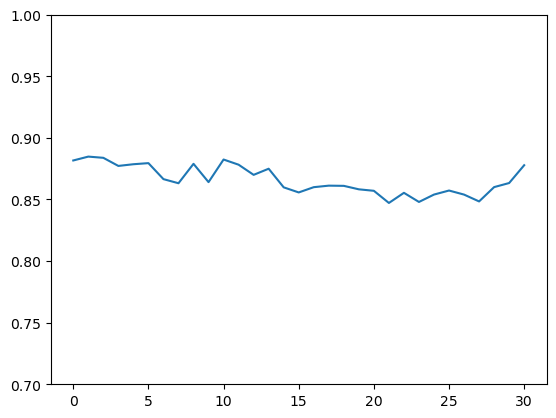

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(len(results)),results)
plt.ylim(0.7,1)
plt.show()

In [8]:
embeddings_snap = []
for t in range(31):
    embeddings = torch.load(f'node-embeddings/covid-flights2/{t}_embeddings.pt')
    embeddings_snap.append(embeddings)

In [9]:
activities = nodeshift.get_activity_vectors(embeddings_snap)

In [100]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

anomaly_scores = []
window = 3 #2 weeks
for t in range(0,1):
    anomaly_scores.append(0)
for t in range(1,len(activities)):
    previous = np.mean(activities[t-window if t-window>=0 else 0:t],axis=0)
    current = activities[t]
    cosine_sim = nodeshift.cosine_sim(current, previous)
    anomaly = 1-nodeshift.cosine_sim(current, previous) if cosine_sim >=0 else abs(cosine_sim)
    anomaly_scores.append(anomaly)

final_scores = []
for t in range(len(anomaly_scores)):
    if t <= window: 
        final_scores.append(0)
    else:
        final_scores.append(max(0,anomaly_scores[t]-sum(anomaly_scores[t-window:t])))
        #final_scores.append(max(0,anomaly_scores[t]-anomaly_scores[t-1]))

In [101]:
[x[0] for x in [(k,v) for k,v in enumerate(final_scores) if v > np.quantile(final_scores, [0.9])]]

[11]

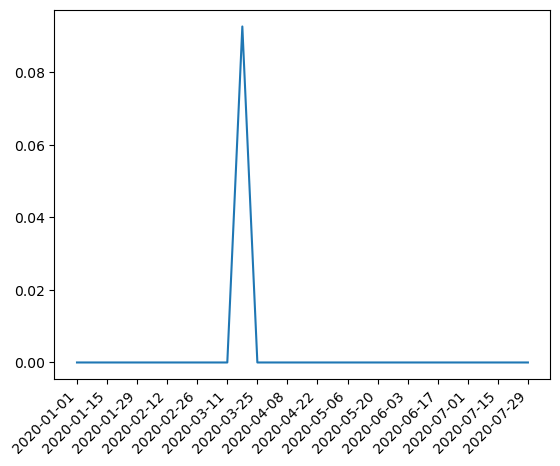

In [102]:
dates = flights_loader.load_dates('datasets/covid-flights/edges_all.txt')
plt.plot(dates[::7],final_scores)
xticks = dates[::7][::2]
plt.xticks(xticks, rotation=45, ha="right")
plt.show()